# Anomaly Detection

Demo Notebooks SAM and Grounded DINO
- https://github.com/xinyu1205/recognize-anything/blob/main/recognize_anything_demo.ipynb
- https://github.com/xinyu1205/recognize-anything/blob/main/gui_demo.ipynb

In [1]:
import os
import sys
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
from mae import mae_vit_base_patch16, mae_vit_large_patch16, mae_vit_huge_patch14
from mae_utils import (
    load_mae,
    process_image,
    show_image,
    visualize_images,
    imagenet_mean,
    imagenet_std,
)

from functools import partial
import glob

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import torch.nn.functional as F
from timm.models.vision_transformer import PatchEmbed, Block
from PIL import Image, ImageDraw, ImageFont

from ram_gdino import (
    extract_objects_from_bounding_boxes,
    detect_objects_with_ram,
    # get_grounding_output,
    inference,
    load_ram,
    load_tag2text,
    load_grounding_dino,
    draw_box,
    # predict_batch
    # load_sam
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [24]:
from groundingdino.util.inference import predict, load_image, annotate

In [2]:
from ram import inference_ram
from groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
import groundingdino.datasets.transforms as T

## Recognize Anything

### Let's resize images for tagging

In [3]:

import torchvision.transforms as TS

NORMALIZE = TS.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
TAGGING_TRANSFORM = TS.Compose([TS.Resize((384, 384)), TS.ToTensor(), NORMALIZE])
GROUNDING_TRANSFORM = T.Compose(
    [
        # T.RandomResize([800], max_size=1333),
        # T.Resize((800, 1200)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_paths = glob.glob(os.path.join(root_dir, "demo*.jpg"))
        self.transform = transform

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path)

        if self.transform is not None:
            image = self.transform(image)

        return image

    def __len__(self):
        return len(self.image_paths)

In [18]:
%%time

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Create the dataset
dataset = ImageDataset("./assets", transform=TAGGING_TRANSFORM)

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=1, num_workers=6)

# Iterate over the DataLoader
for images in dataloader:
    images = images.cuda()
    # GROUNDING_TRANSFORM(stacked_images).unsqueeze(0).to(device)

print(images.shape)
print(images.device)

torch.Size([1, 3, 384, 384])
cuda:0
CPU times: user 173 ms, sys: 35.7 ms, total: 209 ms
Wall time: 332 ms


In [19]:
def inference_ram_batch(image, model):
    with torch.no_grad():
        tags = model.generate_tags_for_batch(image)

    return tags[0]

In [20]:
def process_tags(raw_tags: list):
    # Convert raw_tags into a single list of all words, then get unique words
    all_words = [tag.strip() for sublist in [tags.split(" | ") for tags in raw_tags] for tag in sublist]
    unique_words = list(set(all_words))
    
    # Convert list back to a string
    raw_tags = ', '.join(sorted(unique_words, key=str.lower))

    if not raw_tags.endswith("."):
        raw_tags = raw_tags + "."

    return raw_tags


In [8]:
%%capture
# usually takes around 1min on RTX 3090
ram_model = load_ram(device)
grounding_dino_model = load_grounding_dino(device)

ram_model = ram_model.to(device)
grounding_dino_model = grounding_dino_model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
# Read in images
images = []
img_paths = []

for i in range (1, 25):
    img_path = f"./assets/demo{i}.jpg"
    in_img = Image.open(img_path)
    images.append(in_img)
    img_paths.append(img_path)

len(images), len(img_paths)

(24, 24)

#### Let's pre-process images in a separate step; Optimize using PyTorch transforms on GPU?
- Resizing a batch of 8 and saving it takes approx 255 ms


#### Perform inference RAM (single image)
- takes 241ms for a batch of 8 to perform inference - **30ms / frame**
- 750ms for 24 images
- could be optimized using batch inference

#### Perform Inference RAM using batch (32)

In [22]:
%%time
# Convert your list of image tensors into a single tensor representing the batch
# image_batch = torch.stack(image_tensors).unsqueeze(0).to(device)
with torch.no_grad():
    # Assuming you have an instance of the class containing the `generate_tags_for_batch` function called `model_instance`
    tags = ram_model.generate_tags_for_batch(images)
    # print(tags)

CPU times: user 169 ms, sys: 0 ns, total: 169 ms
Wall time: 168 ms


In [23]:
captions = process_tags(tags)
captions

'bear, bear cub, brown, brown bear, cub, huddle, lake, shore, sit, stand, water.'

#### Batch inference Grounding Dino
- This repo mentions what changes need to be made to current codebase in Grounding_dino: https://github.com/yuwenmichael/Grounding-DINO-Batch-Inference

In [75]:
def predict_batch(
    model,
    images: torch.Tensor,
    caption: str,
    box_threshold: float,
    text_threshold: float,
    device: str = "cuda",
    debug: bool= False
):
    '''
    return: 
        bboxes_batch: list of tensors of shape (n, 4)
        predicts_batch: list of tensors of shape (n,)
        phrases_batch: list of list of strings of shape (n,)
        n is the number of boxes in one image
    '''
    # caption = preprocess_caption(caption=caption)
    # model = model.to(device)
    image = images.to(device)
    with torch.no_grad():
        outputs = model(image, captions=[caption for _ in range(len(images))]) # <------- I use the same caption for all the images for my use-case
    prediction_logits = outputs["pred_logits"].sigmoid()  # prediction_logits.shape = (num_batch, nq, 256)
    prediction_boxes = outputs["pred_boxes"]  # prediction_boxes.shape = (num_batch, nq, 4)

    # import ipdb; ipdb.set_trace()
    mask = prediction_logits.max(dim=2)[0] > box_threshold # mask: torch.Size([num_batch, 256])
    
    bboxes_batch = []
    predicts_batch = []
    phrases_batch = [] # list of lists
    tokenizer = model.tokenizer
    tokenized = tokenizer(caption)
    for i in range(prediction_logits.shape[0]):
        logits = prediction_logits[i][mask[i]]  # logits.shape = (n, 256)
        phrases = [
                    get_phrases_from_posmap(logit > text_threshold, tokenized, tokenizer).replace('.', '')
                    for logit # logit is a tensor of shape (256,) torch.Size([256])
                    in logits # torch.Size([7, 256])
                  ]
        boxes = prediction_boxes[i][mask[i]]  # boxes.shape = (n, 4)
        phrases_batch.append(phrases)
        bboxes_batch.append(boxes)
        predicts_batch.append(logits.max(dim=1)[0])

        if debug:
            image_draw = ImageDraw.Draw(raw_image)
            for box, label in zip(boxes, phrases):
                draw_box(box, image_draw, label)
    
    return bboxes_batch, predicts_batch, phrases_batch

In [76]:
captions

'ball, bar stool, bat, beach, bear, bear cub, black, brown, brown bear, carry, cat, chair, chase, color, corgi, cricket, cricket team, cricketer, cub, dog, draw, dust, field, figurine, floor, frog, game, grass, grassy, green, herd, hill, hillside, horse, huddle, jump, lake, log, lush, mall, man, miniature, mouth, open, park, paw, plain, play, player, puddle, red, referee, reflection, row, run, sand, sheepdog, shore, sit, snail, stand, stick, stone, stool, store, storefront, test, tortoise, toy, tree frog, turtle, water, white, wicket, wild.'

In [78]:
%%timeit
boxes, logits, phrases = predict_batch(
        model=grounding_dino_model,
        images=images,
        caption=captions,
        box_threshold=0.25,
        text_threshold=0.2,
        debug=False # TODO: Fix debug!
    )

764 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
print(len(boxes), len(logits), len(phrases))

32 32 32


In [67]:
import torchvision.transforms as TS
import torchvision
import re

# Threshold Values
box_threshold = 0.25
text_threshold = 0.2
iou_threshold = 0.5

# Normalize and transform the image for tagging model
NORMALIZE = TS.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
TAGGING_TRANSFORM = TS.Compose([TS.Resize((384, 384)), TS.ToTensor(), NORMALIZE])
GROUNDING_TRANSFORM = T.Compose(
    [
        T.RandomResize([800], max_size=1333),
        # Added T.Resize to fix the resized image during batch inference
        # T.Resize((512, 512)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)


@torch.no_grad()
def detect_objects_with_ram(
    raw_image: Image.Image,
    grounding_dino_model: torch.nn.Module,
    ram_model: torch.nn.Module,
    draw_boxes: bool = False,
    label_with_probab: bool = False,
    device: str = "cuda"
    
):
    # print(f"Start processing, image size {raw_image.size}")
    raw_image = raw_image.convert("RGB")

    # Tagging Model
    image = TAGGING_TRANSFORM(raw_image.resize((384, 384))).unsqueeze(0).to(device)
    res = inference_ram(image, ram_model)
    tags = res[0].strip(" ").replace("  ", " ").replace(" |", ",").lower().strip()
    if not tags.endswith("."):
        tags = tags + "."
    print("Tags: ", tags)

    # Use predefined grounding transformation for GroundingDINO model
    image, _ = GROUNDING_TRANSFORM(raw_image, None)
    # grounding_dino_model = grounding_dino_model.to(device)
    image = image.to(device)
    # Do I really need model = grounding_dino_model.to(device)?

    # boxes_filt, scores, pred_phrases = get_grounding_output(
    #     grounding_dino_model, image, tags, box_threshold, text_threshold, device=device
    # )

    outputs = grounding_dino_model(
        image[None], 
        captions=[tags]
    )

    # Extract prediction logits and bounding boxes from the model output
    logits = outputs["pred_logits"].cpu().sigmoid()[0]  # (nq, 256)
    boxes = outputs["pred_boxes"].cpu()[0]  # (nq, 4)
    # logits = logits.to(device); boxes = boxes.to(device)

    # Filter boxes and logits based on the box_threshold
    filt_mask = logits.max(dim=1)[0] > box_threshold
    logits_filt = logits[filt_mask]  # num_filt, 256
    boxes_filt = boxes[filt_mask]  # num_filt, 4

    # Tokenize the caption using the model's tokenizer
    tokenizer = grounding_dino_model.tokenizer
    tokenized = tokenizer(tags)

    # Extract phrases and scores based on the logits and text_threshold
    pred_phrases = []
    scores = []
    for logit, box in zip(logits_filt, boxes_filt):
        pred_phrase = get_phrases_from_posmap(
            logit > text_threshold, tokenized, tokenizer
        )
        pred_phrases.append(pred_phrase + f"({str(logit.max().item())[:4]})")
        scores.append(logit.max().item())

    scores = torch.Tensor(scores)
    size = raw_image.size
    H, W = size[1], size[0]
    for i in range(boxes_filt.size(0)):
        boxes_filt[i] = boxes_filt[i] * torch.Tensor([W, H, W, H]) # Move to CUDA
        boxes_filt[i][:2] -= boxes_filt[i][2:] / 2
        boxes_filt[i][2:] += boxes_filt[i][:2]
    
    print(f"Before NMS: {boxes_filt.shape[0]} boxes")
    nms_idx = torchvision.ops.nms(boxes_filt, scores, iou_threshold).cpu().numpy().tolist()
    boxes_filt = boxes_filt[nms_idx]
    pred_phrases = (
        [pred_phrases[idx] for idx in nms_idx]
        if label_with_probab  # If we want to display the label alongside probability
        else [re.sub(r"\(\d+\.\d+\)", "", pred_phrases[idx]).strip() for idx in nms_idx]
    )
    print(f"After NMS: {boxes_filt.shape[0]} boxes")

    # if draw_boxes:
    image_draw = ImageDraw.Draw(raw_image)
    # label2boxes = []
    for box, label in zip(boxes_filt, pred_phrases):
        draw_box(box, image_draw, label)

    out_image = raw_image.convert("RGBA")

    return out_image, boxes_filt

In [70]:
%%timeit
raw_image = Image.open(f"./assets/demo1.jpg")
# image = TAGGING_TRANSFORM(raw_image.resize((384, 384))).unsqueeze(0).to(device)

ram_out_image,  boxes_filt = detect_objects_with_ram(
    raw_image,
    grounding_dino_model,
    ram_model,
    draw_boxes=True,
    label_with_probab=False,
    device=device

)

# ram_out_image.thumbnail((500, 500))
# display(ram_out_image.convert("RGB"))


# import supervision as sv

# box_annotator = sv.BoxAnnotator()
# annotated_image = box_annotator.annotate(scene=image, detections=detections, labels=labels)

Tags:  adult, bear, bear cub, brown, brown bear, cub, huddle, lake, shore, sit, water.
Before NMS: 21 boxes
After NMS: 6 boxes
Tags:  adult, bear, bear cub, brown, brown bear, cub, huddle, lake, shore, sit, water.
Before NMS: 21 boxes
After NMS: 6 boxes
Tags:  adult, bear, bear cub, brown, brown bear, cub, huddle, lake, shore, sit, water.
Before NMS: 21 boxes
After NMS: 6 boxes
Tags:  adult, bear, bear cub, brown, brown bear, cub, huddle, lake, shore, sit, water.
Before NMS: 21 boxes
After NMS: 6 boxes
Tags:  adult, bear, bear cub, brown, brown bear, cub, huddle, lake, shore, sit, water.
Before NMS: 21 boxes
After NMS: 6 boxes
Tags:  adult, bear, bear cub, brown, brown bear, cub, huddle, lake, shore, sit, water.
Before NMS: 21 boxes
After NMS: 6 boxes
Tags:  adult, bear, bear cub, brown, brown bear, cub, huddle, lake, shore, sit, water.
Before NMS: 21 boxes
After NMS: 6 boxes
Tags:  adult, bear, bear cub, brown, brown bear, cub, huddle, lake, shore, sit, water.
Before NMS: 21 boxes
Aft

In [44]:
%%time
# objects_pool = []
# objects_pool_path = "objects_pool/all_images"
# if not os.path.exists(objects_pool_path):
#     os.mkdir(objects_pool_path)


for i in range(1, 9):
    # Open Image
    in_img = Image.open(f"./assets/demo{i}.jpg")
    # print("-----\n")
    raw_image = in_img.convert("RGB")

    # Tagging Model
    # image = TAGGING_TRANSFORM(raw_image.resize((384, 384))).unsqueeze(0).to(device)
    # save_path = os.path.join(objects_pool_path, f"demo{i}_object{idx}.jpg")
    # obj_image.convert("RGB").save(save_path)

    # inference_ram(image, ram_model)

    # Return tags, bounding boxes, and labels
    # ram_out_image, boxes_filt = detect_objects_with_ram(
    #     raw_image, grounding_dino_model, ram_model, draw_boxes=True, device=device
    # )

    tags, ram_out_image, pred_phrases, boxes_filt = inference_with_ram(
        raw_image,
        do_det_seg=True
    )

    # # Display image
    ram_out_image.thumbnail((500, 500))
    display(ram_out_image.convert("RGB"))

    # # Get object images from using bounding boxes
    current_object_images = extract_objects_from_bounding_boxes(in_img, boxes_filt)

    # Save images to list
    # objects_pool.extend([(obj, phrase[0]) for obj, phrase in zip(current_object_images, pred_phrases)])

    # Save object images to folder
    # for idx, obj_image in enumerate(current_object_images, start=1):
    #     save_path = os.path.join(objects_pool_path, f"demo{i}_object{idx}.jpg")
    #     obj_image.convert("RGB").save(save_path)

NameError: name 'inference_with_ram' is not defined

## Masked AutoEncoder (Scalable Vision Learners)

Demo notebook: https://colab.research.google.com/github/facebookresearch/mae/blob/main/demo/mae_visualize.ipynb

In [6]:
# # Data transformations (you can adjust as needed)
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])

# # Load dataset
# dataset = datasets.ImageFolder(root='objects_pool/', transform=transform)

# # Split dataset into train and validation (you can adjust split ratio)
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# # Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [47]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for imgs, _ in dataloader:  # we don't need labels
        imgs = imgs.to(device)

        # Forward pass
        loss, _, _ = model(imgs)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
    return running_loss / len(dataloader.dataset)

def validate_epoch(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for imgs, _ in dataloader:
            imgs = imgs.to(device)
            loss, _, _ = model(imgs)
            running_loss += loss.item() * imgs.size(0)
    return running_loss / len(dataloader.dataset)

In [8]:
# # Initialize model, criterion and optimizer
# model = mae_vit_large_patch16().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# num_epochs = 20
# for epoch in range(num_epochs):
#     train_loss = train_epoch(model, train_loader, None, optimizer, device)  # criterion is not passed as it's internal to the model
#     val_loss = validate_epoch(model, val_loader, device)
#     print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

# # Save the trained model
# torch.save(model.state_dict(), "masked_autoencoder_vit.pth")

Epoch [1/20] | Train Loss: 0.7964 | Val Loss: 0.1703
Epoch [2/20] | Train Loss: 0.1284 | Val Loss: 0.0729
Epoch [3/20] | Train Loss: 0.0738 | Val Loss: 0.0746
Epoch [4/20] | Train Loss: 0.0790 | Val Loss: 0.0817
Epoch [5/20] | Train Loss: 0.0889 | Val Loss: 0.0904
Epoch [6/20] | Train Loss: 0.0948 | Val Loss: 0.0862
Epoch [7/20] | Train Loss: 0.0879 | Val Loss: 0.0768
Epoch [8/20] | Train Loss: 0.0796 | Val Loss: 0.0721
Epoch [9/20] | Train Loss: 0.0745 | Val Loss: 0.0696
Epoch [10/20] | Train Loss: 0.0709 | Val Loss: 0.0671
Epoch [11/20] | Train Loss: 0.0684 | Val Loss: 0.0655
Epoch [12/20] | Train Loss: 0.0690 | Val Loss: 0.0647
Epoch [13/20] | Train Loss: 0.0676 | Val Loss: 0.0625
Epoch [14/20] | Train Loss: 0.0662 | Val Loss: 0.0618
Epoch [15/20] | Train Loss: 0.0647 | Val Loss: 0.0588
Epoch [16/20] | Train Loss: 0.0619 | Val Loss: 0.0586
Epoch [17/20] | Train Loss: 0.0620 | Val Loss: 0.0601
Epoch [18/20] | Train Loss: 0.0631 | Val Loss: 0.0596
Epoch [19/20] | Train Loss: 0.0638 | 

### Let's run the MAE flow

In [18]:
# load an image
img = Image.open(f"Grounded-Segment-Anything/assets/demo8.jpg")
img = img.resize((224, 224))
img = np.array(img) / 255.0
img = torch.Tensor(img)

print(img.shape)

# assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

# plt.rcParams["figure.figsize"] = [5, 5]
# show_image(torch.tensor(img))

torch.Size([224, 224, 3])


In [19]:
chkpt_dir = "./pretrained/mae_visualize_vit_large.pth"
model_mae = load_mae(chkpt_dir, arch=mae_vit_large_patch16, device=device)

<All keys matched successfully>


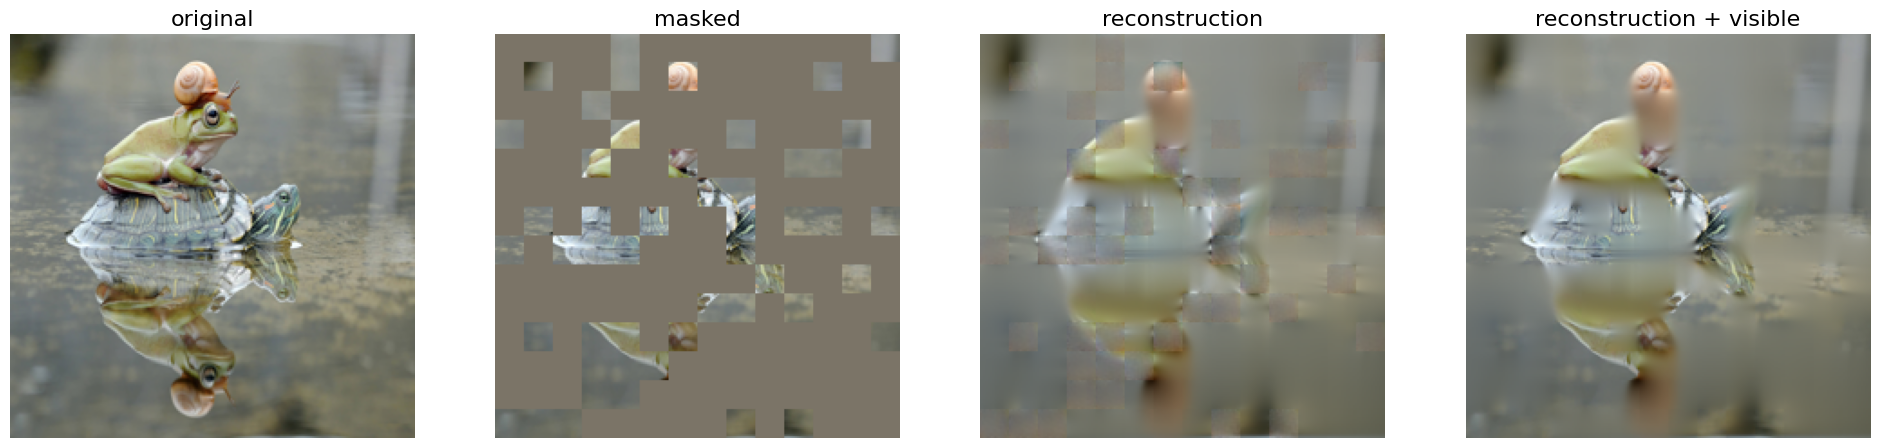

CPU times: user 327 ms, sys: 77.5 ms, total: 404 ms
Wall time: 247 ms


In [20]:
%%time
original, masked, reconstruction, reconstructed_visible = process_image(
    img, model_mae, device=device
)
visualize_images(original, masked, reconstruction, reconstructed_visible)

### Let's say we want to validate multiple images

In [6]:
chkpt_dir = "./pretrained/mae_visualize_vit_large.pth"
model_mae = load_mae(chkpt_dir, arch=mae_vit_large_patch16, device=device)

<All keys matched successfully>


In [7]:
# # Data transformations (you can adjust as needed)
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Resize((16, 16)),
#     transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
# ])

# # Load dataset
# dataset = datasets.ImageFolder(root='objects_pool/', transform=transform)

# # Split dataset into train and validation (you can adjust split ratio)
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# # Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [21]:
# num_epochs = 50
# for epoch in range(num_epochs):
#     train_loss = train_epoch(model_mae, train_loader, None, optimizer, device)  # criterion is not passed as it's internal to the model
#     val_loss = validate_epoch(model_mae, val_loader, device)
#     print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
#     # scheduler.step()

In [7]:
# def validate_epoch(model, dataloader, device):
#     model.eval()
#     running_loss = 0.0
#     with torch.no_grad():
#         for imgs, _ in dataloader:
#             imgs = imgs.to(device)
#             loss, _, _ = model(imgs)
#             running_loss += loss.item() * imgs.size(0)
#     return running_loss / len(dataloader.dataset)

------
Image: 1 | Loss: 0.14486806094646454


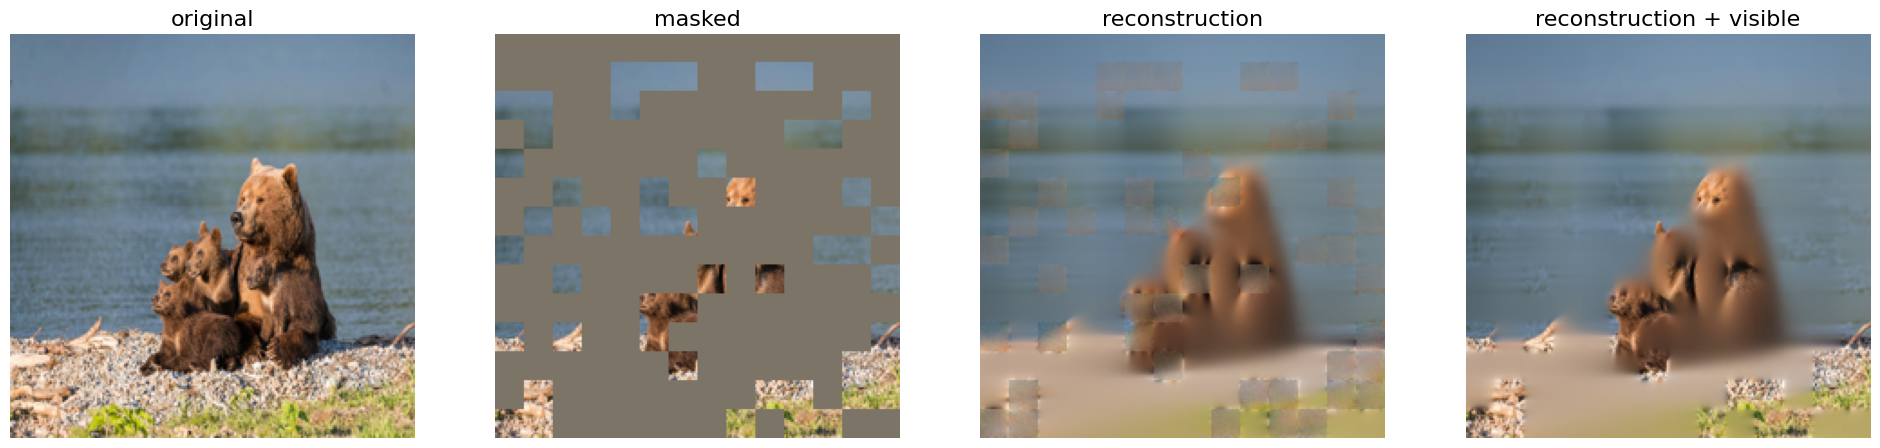

------
Image: 2 | Loss: 0.12039506435394287


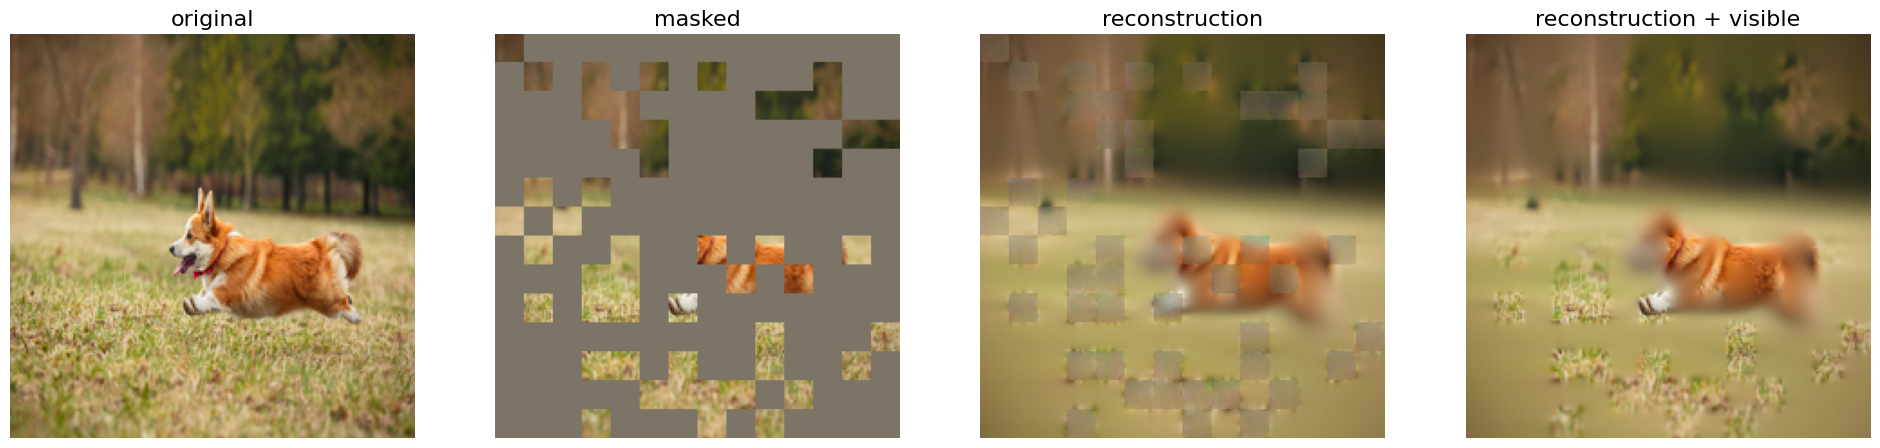

------
Image: 3 | Loss: 0.2879050672054291


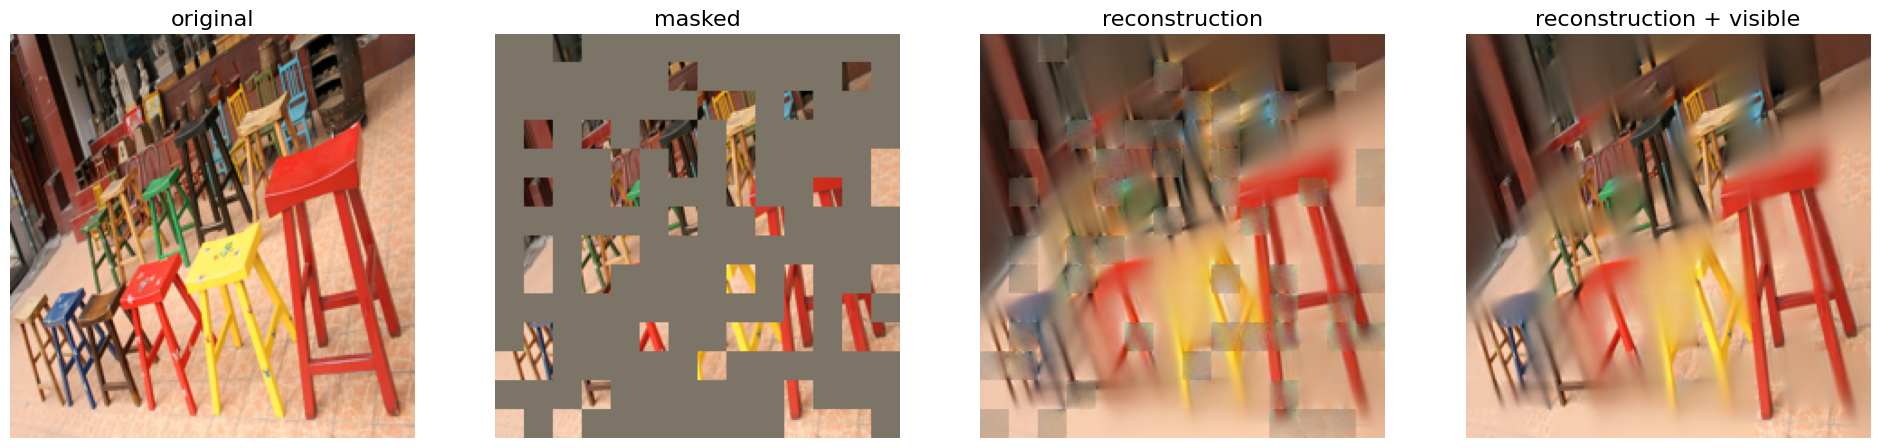

------
Image: 4 | Loss: 0.15174801647663116


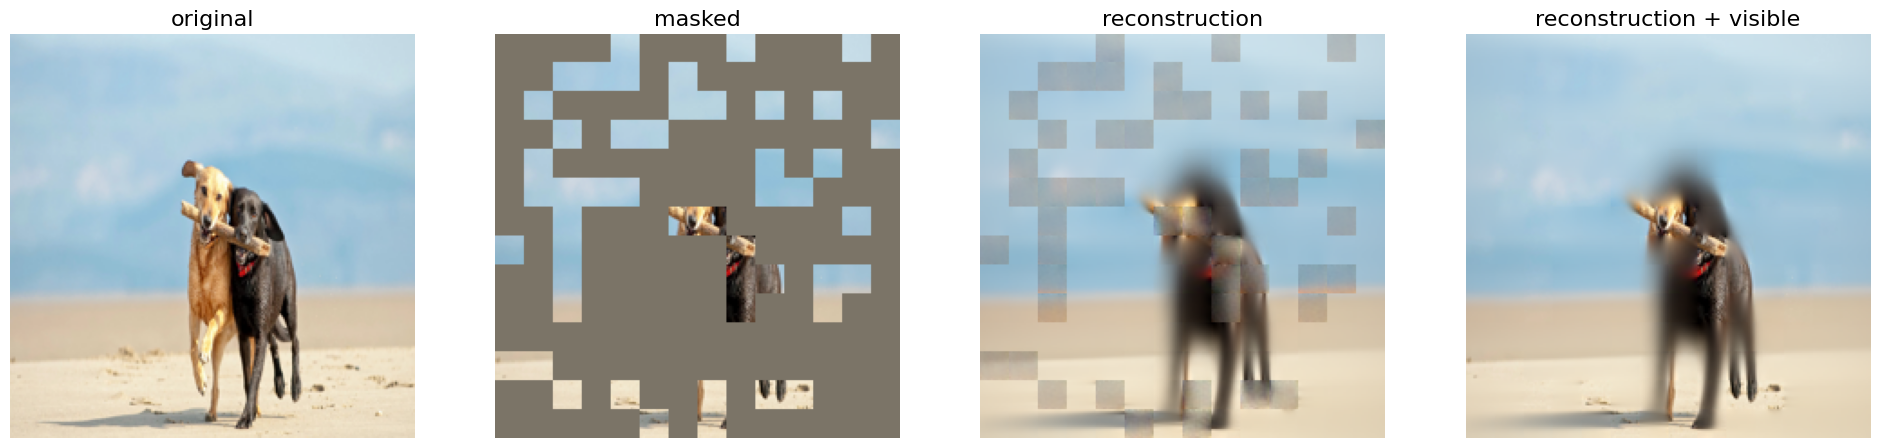

------
Image: 5 | Loss: 0.07150518149137497


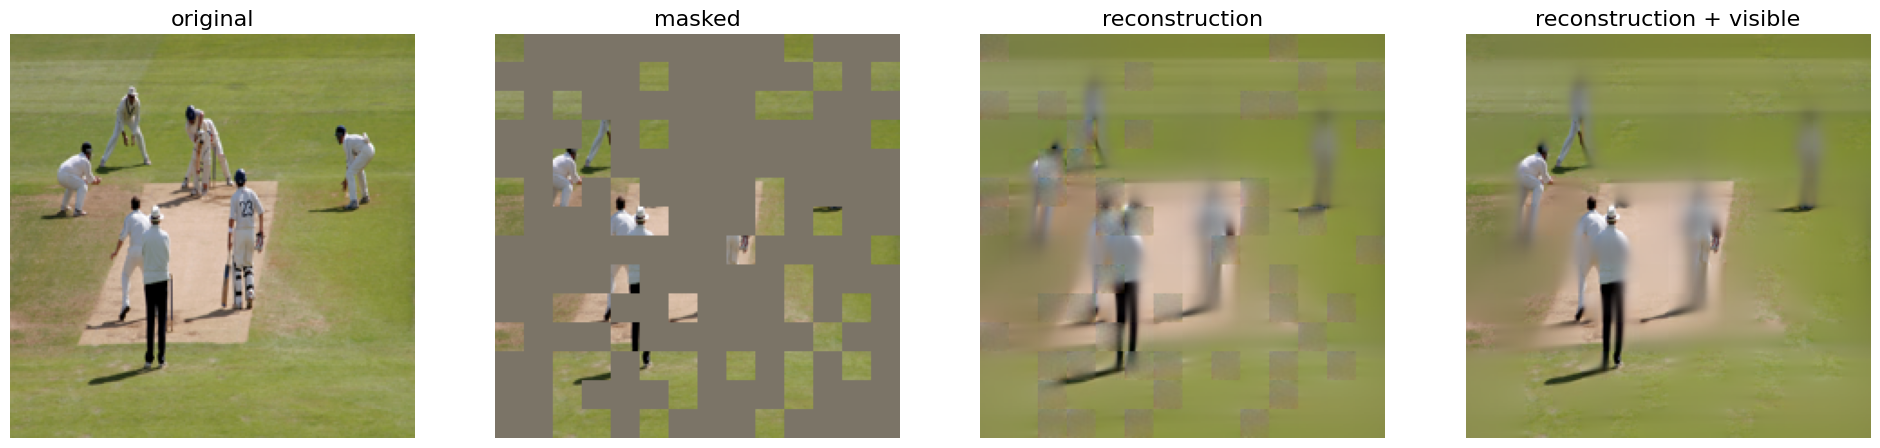

------
Image: 6 | Loss: 0.2759852111339569


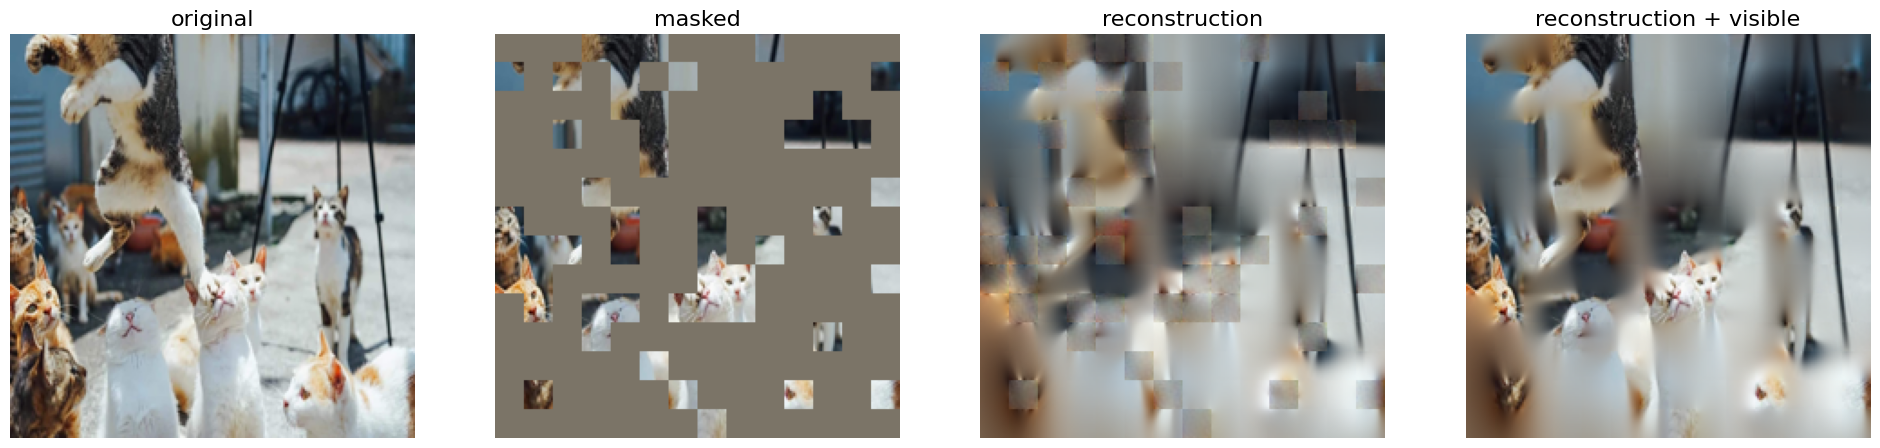

------
Image: 7 | Loss: 0.13869553804397583


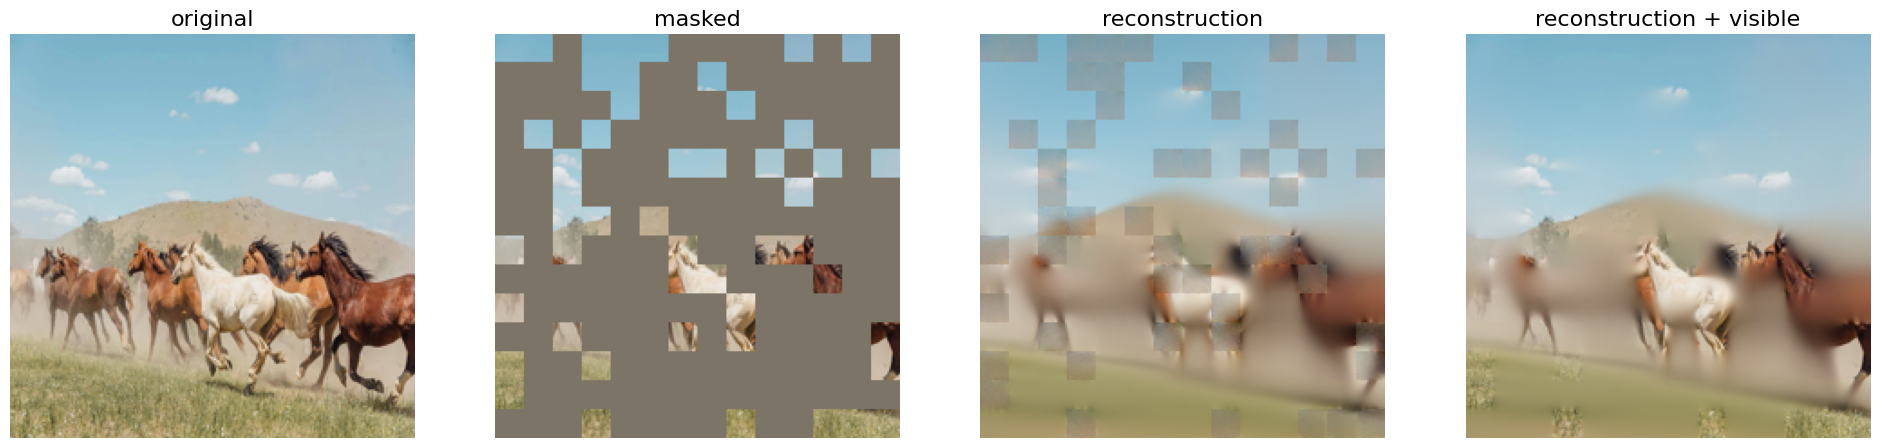

------
Image: 8 | Loss: 0.0860387459397316


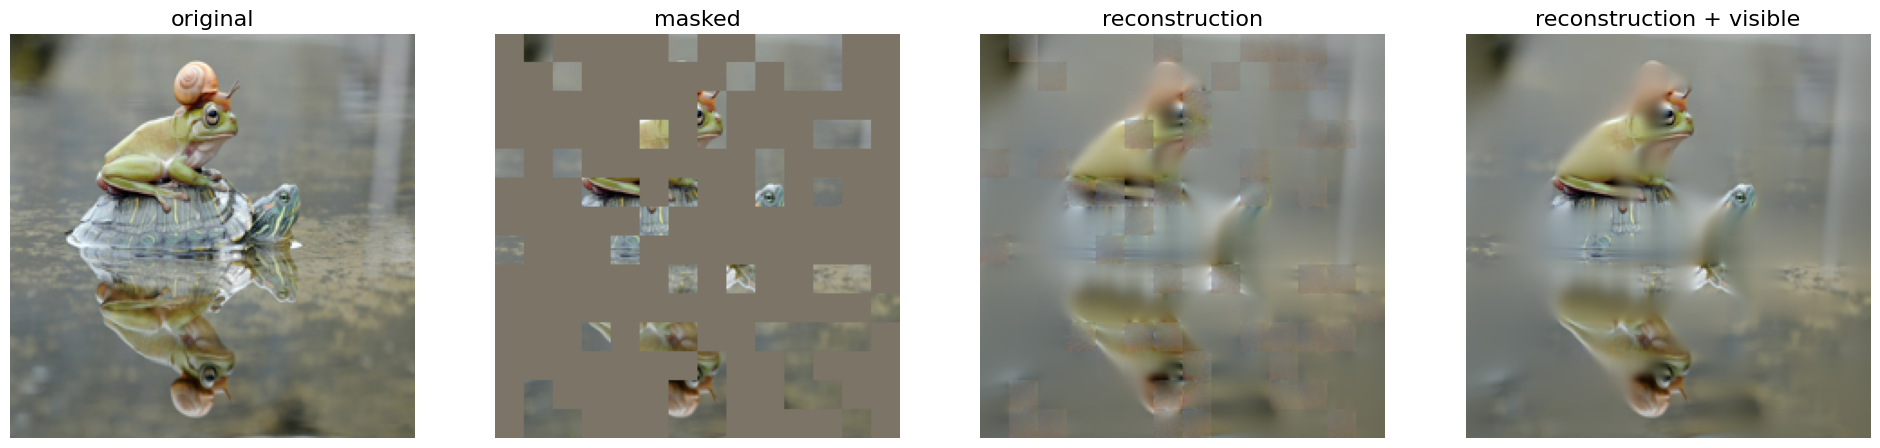

CPU times: user 3.31 s, sys: 680 ms, total: 3.99 s
Wall time: 2.74 s


In [22]:
%%time
for i in range (1, 9):
    # load an image
    img = Image.open(f"Grounded-Segment-Anything/assets/demo{i}.jpg")
    img = img.resize((224, 224))
    img = np.array(img) / 255.0
    img = torch.Tensor(img)
    
    # try:
    print("------")
    # normalize by ImageNet mean and std
    img = img - imagenet_mean
    img = img / imagenet_std

    original, masked, reconstruction, reconstructed_visible = process_image(
        img, model_mae, device=device
    )

    # Compute MSE loss
    mse_loss = F.mse_loss(original, reconstructed_visible)
    print(f"Image: {i} | Loss: {mse_loss.item()}")
    
    visualize_images(original, masked, reconstruction, reconstructed_visible)
    # except:
        # pass

In [71]:
# Data transformations (you can adjust as needed)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

# Load dataset
dataset = datasets.ImageFolder(root='objects_pool/', transform=transform)

# Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

In [72]:
model_mae.eval()
running_loss = 0.0
with torch.no_grad():
    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        loss, _, _ = model_mae(imgs)
        running_loss += loss.item() * imgs.size(0)

print(running_loss / len(dataloader.dataset))

0.24139882157098003
